# Descriptive fit analysis

### Here, I'll look at the descriptive fits to both experimental and simulated/model data to read off and analyze SF tuning properties

In [80]:
import numpy as np
import helper_fcns as hfunc
import autoreload
import matplotlib.pyplot as plt
plt.style.use('paul_plt_style.mplstyle')
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline

save_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/Analysis/Figures'; # local
data_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/Analysis/Structures/'; # local
# save_loc = '/users/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/Analysis/Figures/'; # CNS
# data_loc = '/users/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/Analysis/Structures/'; # CNS
expName = 'dataList.npy';
fitName = 'fitList.npy';
descrName = 'descrFits.npy';
descrModName = 'descrFitsModel.npy';
respName = 'respAboveBase.npy';

muLoc = 2; # mu is in location '2' of parameter arrays

In [92]:
nCells = 59;
nFamilies = 5;
nCons = 2;

useLowRespCut = 1; # should you filter the data based on analysis in "Considering responsivity..."

height = 3/4; # measure BW at half-height
sf_range = [0.01, 10]; # allowed values of 'mu' for fits - see descr_fit.py for details

In [82]:
dataList = np.load(data_loc + expName, encoding='latin1').item();
respAbBase = np.load(data_loc + respName, encoding='latin1')

In [19]:
descrExp = np.load(data_loc + descrName, encoding='latin1').item()
descrMod = np.load(data_loc + descrModName, encoding='latin1').item()

In [111]:
bwMod = np.zeros((nCells, nFamilies, nCons)) * np.nan;
bwExp = np.zeros((nCells, nFamilies, nCons)) * np.nan;

pSfMod = np.zeros((nCells, nFamilies, nCons)) * np.nan;
pSfExp = np.zeros((nCells, nFamilies, nCons)) * np.nan;

### Get bandwidth/prefSf measures organized

In [112]:
for i in descrExp:
    for f in range(nFamilies):
        
        if i in descrMod:
            ignore, bwMod[i, f, 0] = hfunc.compute_SF_BW(descrMod[i]['params'][f, 0, :], height, sf_range)
            ignore, bwMod[i, f, 1] = hfunc.compute_SF_BW(descrMod[i]['params'][f, 1, :], height, sf_range)
            pSfMod[i, f, 0] = descrMod[i]['params'][f, 0, muLoc]
            pSfMod[i, f, 1] = descrMod[i]['params'][f, 1, muLoc]

        if i in descrExp:
            ignore, bwExp[i, f, 0] = hfunc.compute_SF_BW(descrExp[i]['params'][f, 0, :], height, sf_range)
            ignore, bwExp[i, f, 1] = hfunc.compute_SF_BW(descrExp[i]['params'][f, 1, :], height, sf_range)
            pSfExp[i, f, 0] = descrExp[i]['params'][f, 0, muLoc]
            pSfExp[i, f, 1] = descrExp[i]['params'][f, 1, muLoc]

In [113]:
bwDiffMod = bwMod[:, :, 0] - bwMod[:,:,1]
bwDiffExp = bwExp[:, :, 0] - bwExp[:,:,1]

pSfRatioMod = pSfMod[:, :, 0] / pSfMod[:,:,1]
pSfRatioExp = pSfExp[:, :, 0] / pSfExp[:,:,1]

### Considering responsivity at low contrast & high dispersion

Inspired by chats with Najib, I should ensure that the effect of dispersion on contrast dependent shifts holds if we look only at cells with meaningful responses at the low contrast, maximal dispersion case.

In [114]:
peakCrit = 10; # i.e. cells with maximum response at low con/high disp condition below this won't be counted
sumCrit = 0.1; # i.e. cells whose sum of responses '''''' as a fraction of the same at high con/low disp won't be counted

In [115]:
nCells = len(dataList['unitName']);
peaks = np.zeros((nCells, 2)); # do (, 2) so we can compare high con/low disp to low con/high disp
sums = np.zeros((nCells, 2));

for c in range(nCells):
    responses = respAbBase[c, :, :, :];
    
    peaks[c, 0] = np.amax(responses[0][0]); # peak response for single grating, high contrast
    sums[c, 0] = np.sum(responses[0][0]);
    
    peaks[c, 1] = np.amax(responses[4][1]); # ' ' for maximum dispersion, low contrast
    sums[c, 1] = np.sum(responses[4][1]);

In [116]:
if useLowRespCut: # for now, use peakCrit
    keepCells = peaks[:, 1] > peakCrit;
    
    bwMod = bwMod[keepCells, :];
    bwExp = bwExp[keepCells, :];
    
    pSfExp = pSfExp[keepCells, :];
    pSfMod = pSfMod[keepCells, :];
    
    bwDiffMod = bwDiffMod[keepCells, :];
    bwDiffExp = bwDiffExp[keepCells, :];

    pSfRatioMod = pSfRatioMod[keepCells, :];
    pSfRatioExp = pSfRatioExp[keepCells, :];

### Plot BW differences

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


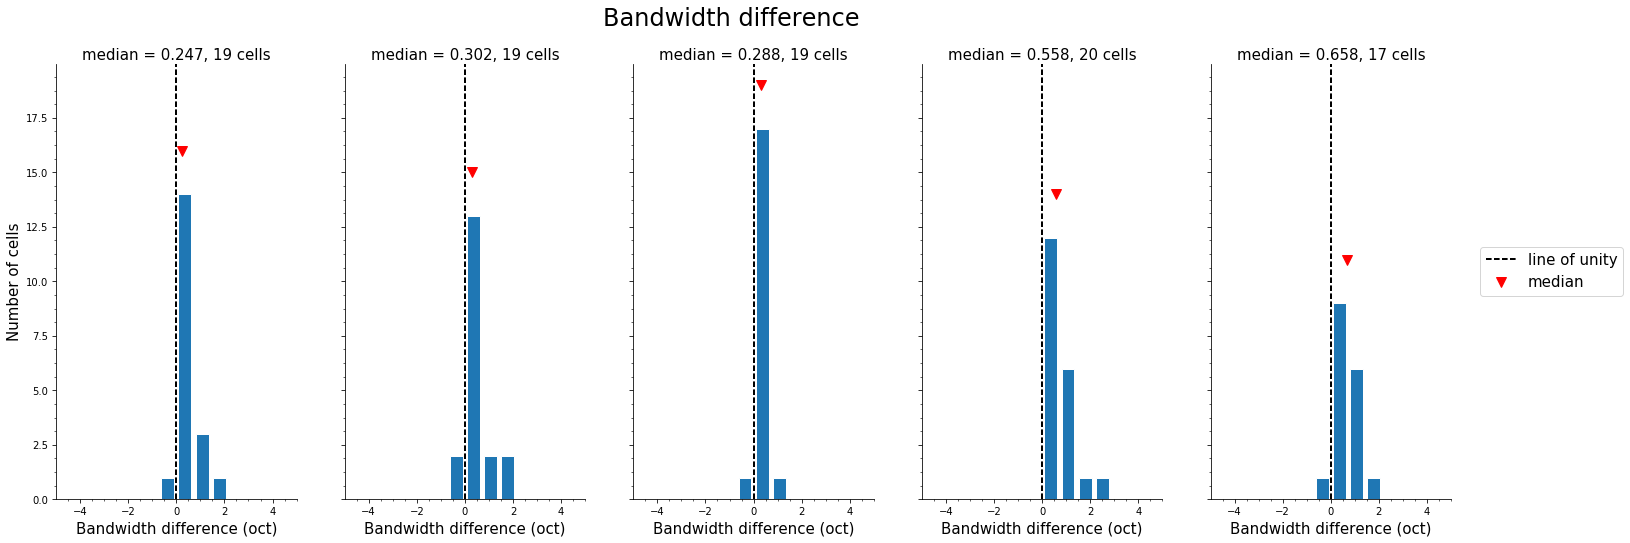

In [117]:
fig, allBW = plt.subplots(1, nFamilies, sharex='col', sharey='row', figsize=(25,8))

allBW[0].set_ylabel('Number of cells', fontsize=15);
binRange = (-5, 5)
nBins = 15;
binz = np.linspace(binRange[0], binRange[1], num=nBins);

for fam in range(nFamilies):
    validOnesExp = np.logical_and(bwDiffExp[:,fam]>-5, pSfRatioExp[:,fam]<5);
    toConsider = bwDiffExp[validOnesExp, fam];
    countz = allBW[fam].hist(toConsider, binz, alpha=1, rwidth=0.75);
    
    medianRatio = np.median(toConsider);
    allBW[fam].hold;
    
    unity = allBW[fam].axvline(0, ls='--', color='k', linewidth=2);
    medPt = allBW[fam].plot(medianRatio, np.amax(countz[0])+2, 'rv', markersize=10);
    
    allBW[fam].set_xlabel('Bandwidth difference (oct)', fontsize=15);
    allBW[fam].set_xlim(binRange);
    
    allBW[fam].text(0.5, 1.01,'median = {:.3f}, {:.0f} cells'.format(medianRatio, sum(countz[0])), horizontalalignment='center',\
                     transform=allBW[fam].transAxes, FontSize=15)
    
fig.legend((unity, medPt[0]), ('line of unity', 'median'), fontsize=15, loc='right');
plt.suptitle('Bandwidth difference', fontsize=24);

### Plot pSf ratios

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


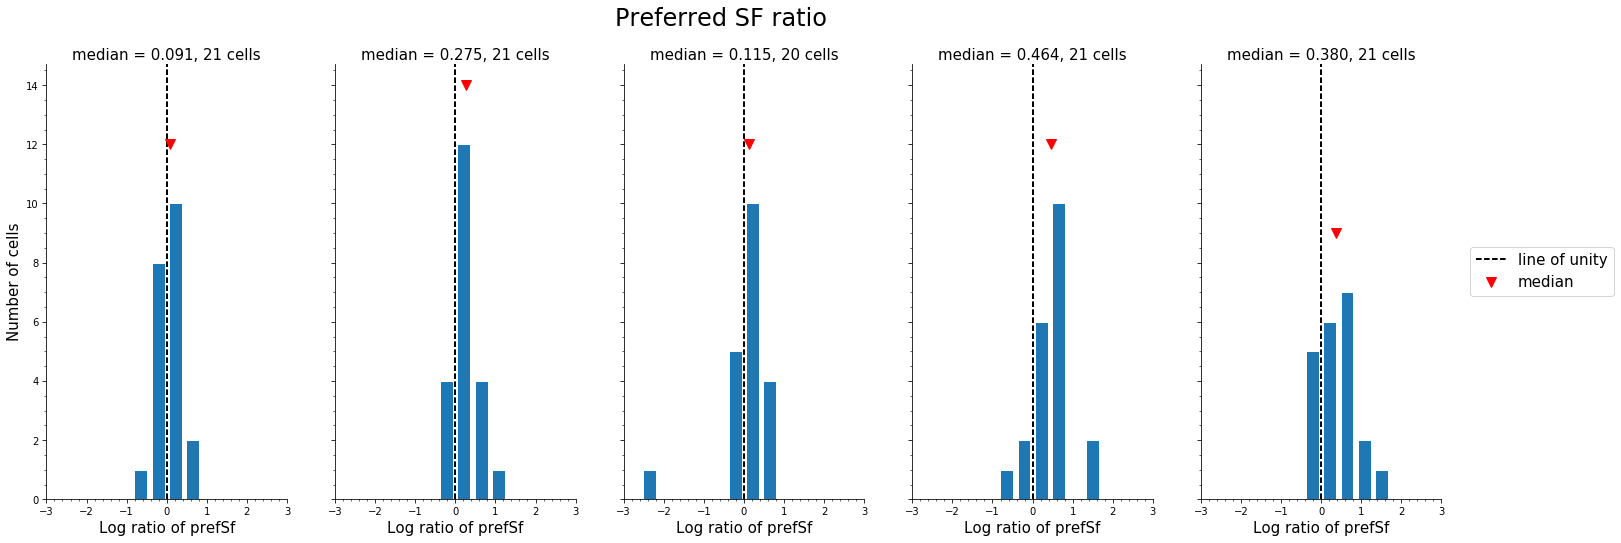

In [118]:
fig, allpSf = plt.subplots(1, nFamilies, sharex='col', sharey='row', figsize=(25,8))

allpSf[0].set_ylabel('Number of cells', fontsize=15)
binRange = (-3, 3) # in log2 space...
nBins = 15;
binz = np.linspace(binRange[0], binRange[1], num=nBins)

for fam in range(nFamilies):
    validOnesExp = np.logical_and(pSfRatioExp[:,fam]>0, pSfRatioExp[:,fam]<10);
    toConsider = np.log2(pSfRatioExp[validOnesExp, fam]);
    countz = allpSf[fam].hist(toConsider, binz, alpha=1, rwidth=0.75)

    medianRatio = np.median(toConsider);
    allpSf[fam].hold

    unity = allpSf[fam].axvline(0, ls='--', color='k', linewidth=2)
    medPt = allpSf[fam].plot(medianRatio, np.amax(countz[0])+2, 'rv', markersize=10)
    
    allpSf[fam].set_xlabel('Log ratio of prefSf', fontsize=15)
    allpSf[fam].set_xlim(binRange)
    
    allpSf[fam].text(0.5, 1.01,'median = {:.3f}, {:.0f} cells'.format(medianRatio, sum(countz[0])), horizontalalignment='center',\
                     transform=allpSf[fam].transAxes, FontSize=15)
    
fig.legend((unity, medPt[0]), ('line of unity', 'median'), fontsize=15, loc='right');
plt.suptitle('Preferred SF ratio', fontsize=24);

In [119]:
#plt.matplotlib.font_manager.findSystemFonts()

### Relationship between prefSf and sfBW (octaves)

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


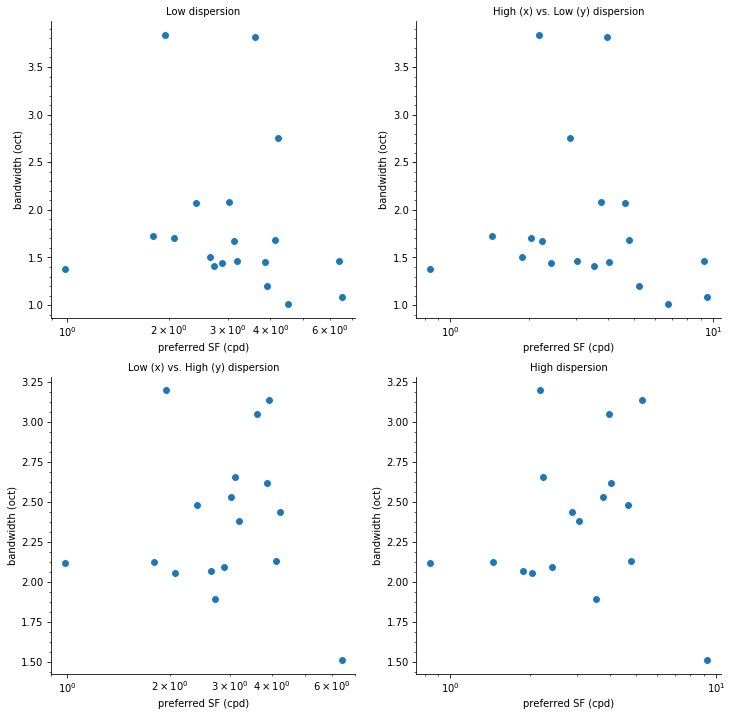

In [120]:
fig, prefVbw = plt.subplots(2, 2, figsize = (12, 12));

pSfLow = pSfExp[:, 0, 0]; # pSf at low dispersion, high contrast
pSfHigh = pSfExp[:, 4, 0]; # pSf at high dispersion, high contrast

sfBwLow = bwExp[:, 0, 0]; # pSf at low dispersion, high contrast
sfBwHigh = bwExp[:, 4, 0]; # pSf at high dispersion, high contrast

# Low versus Low
prefVbw[0, 0].semilogx(pSfLow, sfBwLow, 'o', mec='white');
prefVbw[0, 0].set_xlabel('preferred SF (cpd)');
prefVbw[0, 0].set_ylabel('bandwidth (oct)');
prefVbw[0, 0].set_title('Low dispersion');

# Low versus High
prefVbw[1, 0].semilogx(pSfLow, sfBwHigh, 'o', mec='white');
prefVbw[1, 0].set_xlabel('preferred SF (cpd)');
prefVbw[1, 0].set_ylabel('bandwidth (oct)');
prefVbw[1, 0].set_title('Low (x) vs. High (y) dispersion');

# High versus Low
prefVbw[0, 1].semilogx(pSfHigh, sfBwLow, 'o', mec='white');
prefVbw[0, 1].set_xlabel('preferred SF (cpd)');
prefVbw[0, 1].set_ylabel('bandwidth (oct)');
prefVbw[0, 1].set_title('High (x) vs. Low (y) dispersion');

# High versus high
prefVbw[1, 1].semilogx(pSfHigh, sfBwHigh, 'o', mec='white');
prefVbw[1, 1].set_xlabel('preferred SF (cpd)');
prefVbw[1, 1].set_ylabel('bandwidth (oct)');
prefVbw[1, 1].set_title('High dispersion');


### Relationship between prefSf and sfBw (linear cpd)

#### Just a sanity check for correlation between prefSf and linear bandwidth

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


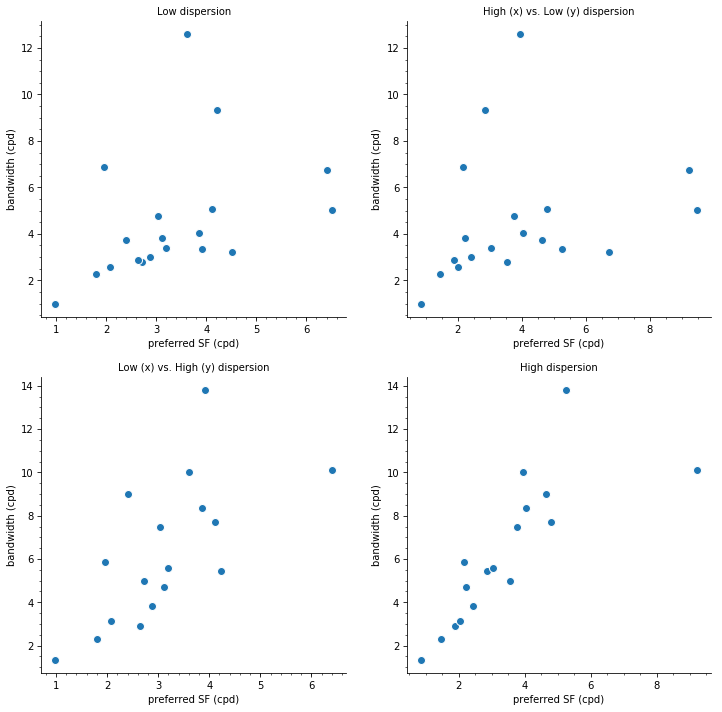

In [121]:
fig, prefVbw = plt.subplots(2, 2, figsize = (12, 12));

pSfLow = pSfExp[:, 0, 0]; # pSf at low dispersion, high contrast
pSfHigh = pSfExp[:, 4, 0]; # pSf at high dispersion, high contrast

sfBwLow = bwExp[:, 0, 0]; # pSf at low dispersion, high contrast
sfBwHigh = bwExp[:, 4, 0]; # pSf at high dispersion, high contrast

linLow = hfunc.bw_log_to_lin(sfBwLow, pSfLow);
linHigh = hfunc.bw_log_to_lin(sfBwHigh, pSfHigh);

# Low versus Low
prefVbw[0, 0].plot(pSfLow, linLow[0], 'o', mec='white');
prefVbw[0, 0].set_xlabel('preferred SF (cpd)');
prefVbw[0, 0].set_ylabel('bandwidth (cpd)');
prefVbw[0, 0].set_title('Low dispersion');

# Low versus High
prefVbw[1, 0].plot(pSfLow, linHigh[0], 'o', mec='white');
prefVbw[1, 0].set_xlabel('preferred SF (cpd)');
prefVbw[1, 0].set_ylabel('bandwidth (cpd)');
prefVbw[1, 0].set_title('Low (x) vs. High (y) dispersion');

# High versus Low
prefVbw[0, 1].plot(pSfHigh, linLow[0], 'o', mec='white');
prefVbw[0, 1].set_xlabel('preferred SF (cpd)');
prefVbw[0, 1].set_ylabel('bandwidth (cpd)');
prefVbw[0, 1].set_title('High (x) vs. Low (y) dispersion');

# High versus high
prefVbw[1, 1].plot(pSfHigh, linHigh[0], 'o', mec='white');
prefVbw[1, 1].set_xlabel('preferred SF (cpd)');
prefVbw[1, 1].set_ylabel('bandwidth (cpd)');
prefVbw[1, 1].set_title('High dispersion');


### Correlations between preferred SF and ratio of pSf high/low

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


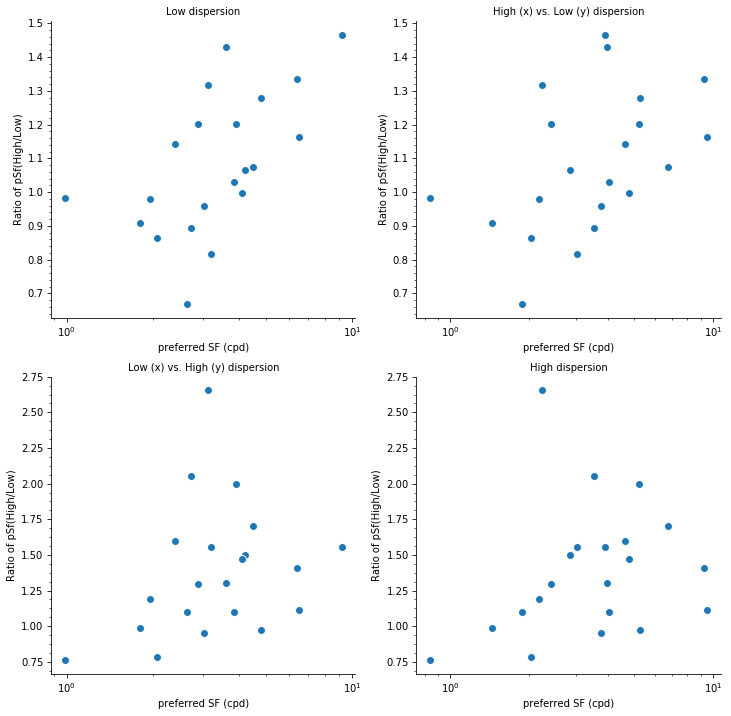

In [122]:
fig, pSfCorr = plt.subplots(2, 2, figsize = (12, 12));

pSfLow = pSfExp[:, 0, 0]; # pSf at low dispersion, high contrast
pSfShiftLow = pSfRatioExp[:, 0]; # ratio of pSf at high/low contrast for low dispersion

pSfHigh = pSfExp[:, 4, 0]; # pSf at high dispersion, high contrast
pSfShiftHigh = pSfRatioExp[:, 4]; # ratio of pSf at high/low contrast for high dispersion

# Low versus Low
pSfCorr[0, 0].semilogx(pSfLow, pSfShiftLow, 'o', mec='white');
pSfCorr[0, 0].set_xlabel('preferred SF (cpd)');
pSfCorr[0, 0].set_ylabel('Ratio of pSf(High/Low)');
pSfCorr[0, 0].set_title('Low dispersion');

# Low versus High
pSfCorr[1, 0].semilogx(pSfLow, pSfShiftHigh, 'o', mec='white');
pSfCorr[1, 0].set_xlabel('preferred SF (cpd)');
pSfCorr[1, 0].set_ylabel('Ratio of pSf(High/Low)');
pSfCorr[1, 0].set_title('Low (x) vs. High (y) dispersion');

# High versus Low
pSfCorr[0, 1].semilogx(pSfHigh, pSfShiftLow, 'o', mec='white');
pSfCorr[0, 1].set_xlabel('preferred SF (cpd)');
pSfCorr[0, 1].set_ylabel('Ratio of pSf(High/Low)');
pSfCorr[0, 1].set_title('High (x) vs. Low (y) dispersion');

# High versus high
pSfCorr[1, 1].semilogx(pSfHigh, pSfShiftHigh, 'o', mec='white');
pSfCorr[1, 1].set_xlabel('preferred SF (cpd)');
pSfCorr[1, 1].set_ylabel('Ratio of pSf(High/Low)');
pSfCorr[1, 1].set_title('High dispersion');


### Correlations between measured BW and difference of bandwidth high-low (oct)

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


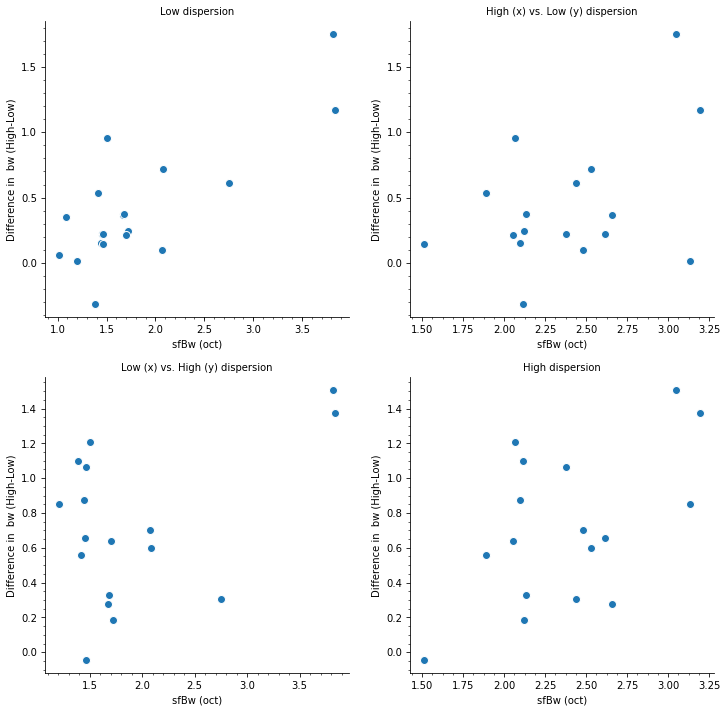

In [123]:
fig, sfBwCorr = plt.subplots(2, 2, figsize = (12, 12));

sfBwLow = bwExp[:, 0, 0]; # pSf at low dispersion, high contrast
sfBwShiftLow = bwDiffExp[:, 0]; # ratio of pSf at high/low contrast for low dispersion

sfBwHigh = bwExp[:, 4, 0]; # pSf at high dispersion, high contrast
sfBwShiftHigh = bwDiffExp[:, 4]; # ratio of pSf at high/low contrast for high dispersion

# Low versus Low
sfBwCorr[0, 0].plot(sfBwLow, sfBwShiftLow, 'o', mec='white');
sfBwCorr[0, 0].set_xlabel('sfBw (oct)');
sfBwCorr[0, 0].set_ylabel('Difference in  bw (High-Low)');
sfBwCorr[0, 0].set_title('Low dispersion');

# Low versus High
sfBwCorr[1, 0].plot(sfBwLow, sfBwShiftHigh, 'o', mec='white');
sfBwCorr[1, 0].set_xlabel('sfBw (oct)');
sfBwCorr[1, 0].set_ylabel('Difference in  bw (High-Low)');
sfBwCorr[1, 0].set_title('Low (x) vs. High (y) dispersion');

# High versus Low
sfBwCorr[0, 1].plot(sfBwHigh, sfBwShiftLow, 'o', mec='white');
sfBwCorr[0, 1].set_xlabel('sfBw (oct)');
sfBwCorr[0, 1].set_ylabel('Difference in  bw (High-Low)');
sfBwCorr[0, 1].set_title('High (x) vs. Low (y) dispersion');

# High versus high
sfBwCorr[1, 1].plot(sfBwHigh, sfBwShiftHigh, 'o', mec='white');
sfBwCorr[1, 1].set_xlabel('sfBw (oct)');
sfBwCorr[1, 1].set_ylabel('Difference in  bw (High-Low)');
sfBwCorr[1, 1].set_title('High dispersion');
